<img src="https://monkeylearn.com/static/6700dcab9bcc691104dd0d794f6e7ef4/Sentiment-analysis-of-Twitter-Social.png" length="100px" width="1000px">

# Twitter sentiment analysis - Extracting emotions through machine learning
* Sentiment analysis is the automatic manner of analyzing textual content and sorting it into sentiments positive, negative, or neutral. Sentiment analysis is used to investigate opinions in Twitter data and it can assist organizations to analyse and understand about their brand. Twitter Sentiment Analysis is a stream of Social network analysis. This is also known as opinion mining

* We import numpy, pandas, matplotlib, and seaborn for data analysis and visualization
* We import wordcloud for EDA
* We import re, string, nltk, spacy for tweets cleaning
* We import sklearn and Xgboost for machine learning and metrics

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# setting up the background style for the plots
plt.style.use('fivethirtyeight')

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer

import spacy
nlp = spacy.load('en')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
train_df = pd.read_csv('train.csv')
print('Train dataset shape: ', train_df.shape)
print('Train dataset columns: ', train_df.columns)

Train dataset shape:  (31962, 3)
Train dataset columns:  Index(['id', 'label', 'tweet'], dtype='object')


In [3]:
#selecting necessary features from train data
train_df = train_df[['label','tweet']]

### Exploratory Data Analysis

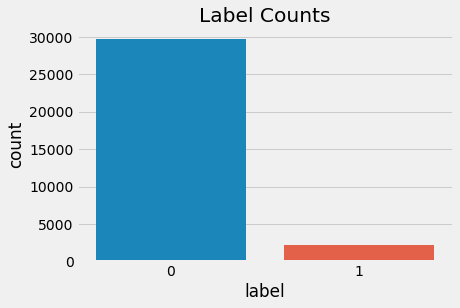

In [4]:
#Labbel Categories count
sns.countplot(x= train_df['label'])
plt.title('Label Counts')
plt.show()

* by the above plot we can understand that in our data most of the data labelled as 0 with means positive sentiment, on the other hand label = 1 means negative sentiment.

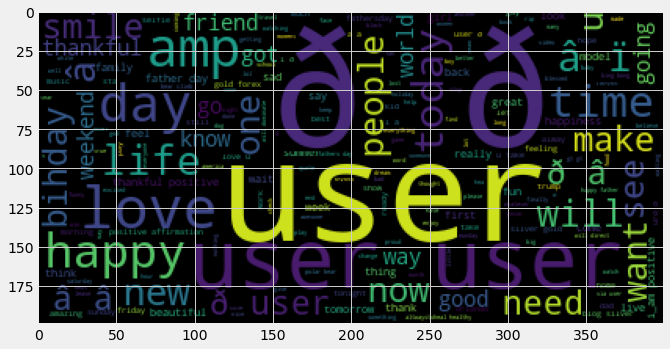

In [5]:
from wordcloud import WordCloud

sentences = train_df['tweet'].tolist()
sentences_ss = " ".join(sentences)

plt.figure(figsize=(10,10))
plt.imshow(WordCloud().generate(sentences_ss))

* With the help of wordcloud we can find most repeated words easily from the whole dataset. By the above image we can come to a conclusion that in our data 'user' is the word which repeated more number of times. And we have some unknown symbols also in our data. So, befor proceeding with modelling, we should first clean the data.

### Word Frequency Analysis

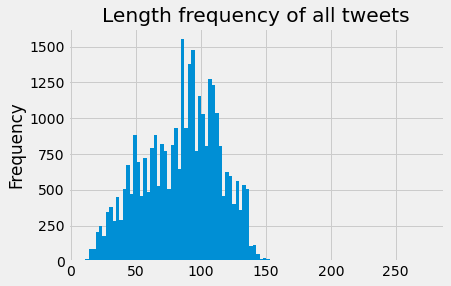

In [6]:
train_df['tweet'].apply(len).plot(bins=100, kind = 'hist')
plt.title('Length frequency of all tweets')
plt.show()

* The above histogram shows us the length frequency of the each tweet from the dataset

### Spliting dataset into input(X) and target(y)

In [7]:
X = train_df.iloc[:,[1]]
y = train_df.iloc[:,0]

### Cleaning of Tweets

In this cleaning process we are going to do the following steps
* removing @usernames 
* converting all words into lowercase
* removing numbers
* removing punctuations
* removing URLs
* tokanize each tweet -> Tokenization is a way of separating a piece of text (sentence) into smaller units called tokens.
* remove while spaces
* remove stop words -> “stop words” usually refers to the most common words in a language, like is, are, the, a, an, and so on
* removing non alphabetics tokens
* performing lemmatization -> remove inflectional endings only i.e. running, runner == run

In [8]:
# Remove @usernames
X['tweet'] = X['tweet'].map(lambda x: re.sub('@\S+', ' ', x))

#all lower case
X['tweet']=X['tweet'].map(lambda x: x.lower())

# Remove numbers
X['tweet'] = X['tweet'].map(lambda x: re.sub(r'\d+', ' ', x))

# Remove Punctuation
X['tweet']  = X['tweet'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))

# Remove urls
url_cleaner = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
X['tweet'] = X['tweet'].map(lambda x: re.sub(url_cleaner, ' ', x))

# Remove white spaces
X['tweet'] = X['tweet'].map(lambda x: x.strip())

# Tokenizer
X['tweet'] = X['tweet'].map(lambda x: word_tokenize(x))

# Remove stop words
stop_words = set(stopwords.words('english'))
X['tweet'] = X['tweet'].map(lambda x: [w for w in x if not w in stop_words])

# Remove non alphabetic tokens
X['tweet'] = X['tweet'].map(lambda x: [w for w in x if w.isalpha()])

# turning back to string
X['tweet'] = X['tweet'].map(lambda x: ' '.join(x))

#Lemmatizer
X['tweet']=X["tweet"].apply(lambda x: " ".join([w.lemma_ for w in nlp(x)]))

### Processing the Data

In [9]:
import gensim

documents = [_text.split() for _text in X.tweet] 
w2v_model = gensim.models.word2vec.Word2Vec(size=200, 
                                            window=5, 
                                            min_count=3, 
                                            workers=6)
w2v_model.build_vocab(documents)

In [10]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 8414


### Finding Similar words

In [11]:
w2v_model.train(documents, total_examples=len(documents), epochs=30)

(6116783, 7640460)

In [12]:
#Test word embeddings
w2v_model.most_similar("job")

[('jobsearch', 0.5665280818939209),
 ('result', 0.5286853313446045),
 ('making', 0.5078350305557251),
 ('offer', 0.503779947757721),
 ('path', 0.501727283000946),
 ('work', 0.4976600408554077),
 ('pofolio', 0.48107171058654785),
 ('lead', 0.47170519828796387),
 ('highfive', 0.46040838956832886),
 ('rajan', 0.45785510540008545)]

In [13]:
train_corpus = []

for i in range(0, 31962):
  review = re.sub('[^a-zA-Z]', ' ', X['tweet'][i])
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review]
  
  # joining them back with space
  review = ' '.join(review)
  train_corpus.append(review)

### CountVectorizer
* CountVectorization is usedd to create a sparse matrix representing all the words in the dataset

In [14]:
cv = CountVectorizer(max_features = 3000)
x = cv.fit_transform(train_corpus).toarray()

print(x.shape)
print(y.shape)

(31962, 3000)
(31962,)


### Sentiment Analysis

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.20, random_state = 46)

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_val = sc.transform(x_val)

In [16]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred_dt = model.predict(x_val)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_val, y_val))


Training Accuracy : 0.9992178028080879
Validation Accuracy : 0.9397778820585014


In [17]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred_rf = model.predict(x_val)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_val, y_val))

Training Accuracy : 0.9991395830888967
Validation Accuracy : 0.9529172532457375


In [18]:
model = XGBClassifier()
model.fit(x_train, y_train)

y_pred_xg = model.predict(x_val)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_val, y_val))

Training Accuracy : 0.9613203488599475
Validation Accuracy : 0.9511966213045518


In [19]:
# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_val, y_pred_rf))

# confusion matrix
cm = confusion_matrix(y_val, y_pred_rf)
print(cm)

f1 score : 0.6324786324786325
[[5833   91]
 [ 210  259]]


### Conclusion:
* Twitter Sentiment analysis helps to monitor and analyse the emotions of human beings based on their tweets. 
* In this project work, Random forest classifier, Decission tree classifier, and XGBoost classifiers are used to perform Twitter sentiment analysis, out of these 3 algorithms Random Forest classifier works well and it prediction score is 95.13%.
* nltk and Spacy has been used in this project to do the natural language processing job.
* In future, we can extract data directly from twitter through api and we can analyze with the random forest.
* We can also improve accuracy by doing prameter tuning using gridsearcv or randomizedsearchcv

### Reference:

* https://github.com/sharmaroshan/Twitter-Sentiment-Analysis/blob/master/Twitter_Sentiment.ipynb
* https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk
* https://towardsdatascience.com/twitter-sentiment-analysis-classification-using-nltk-python-fa912578614c
* https://monkeylearn.com/blog/sentiment-analysis-of-twitter/

                  ------------ Thanks for this opportunity, Have a great day and happy analyzing -----------------